In [ ]:
!jt -t grade3 -fs 95 -altp -tfs 11 -nfs 115 -cellw 75% -T

## Sampling from a GP Prior

Code taken from: https://peterroelants.github.io/posts/gaussian-process-tutorial/


In [1]:
import sys
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

from scipy.stats import multivariate_normal
from sklearn.gaussian_process.kernels import RBF

sns.set_style('darkgrid')
np.random.seed(42)

In [2]:
kernel = 1.0 * RBF(1.0)

n = 100 # number of points per function sample
n_func = 7 # number of functions to sample
L = -5; U = 5

# start with X = (x_1, x_2, ..., x_n)
X = np.linspace(L, U, n).reshape(-1, 1)

#  use kernel to calculate the covariance matrix
K = kernel(X)

# use the covariance matrix and zero-vector for the mean to parametize a multivariate Gaussian
ys = multivariate_normal.rvs(mean = np.zeros(n), 
                             cov = K, 
                             size = n_func)

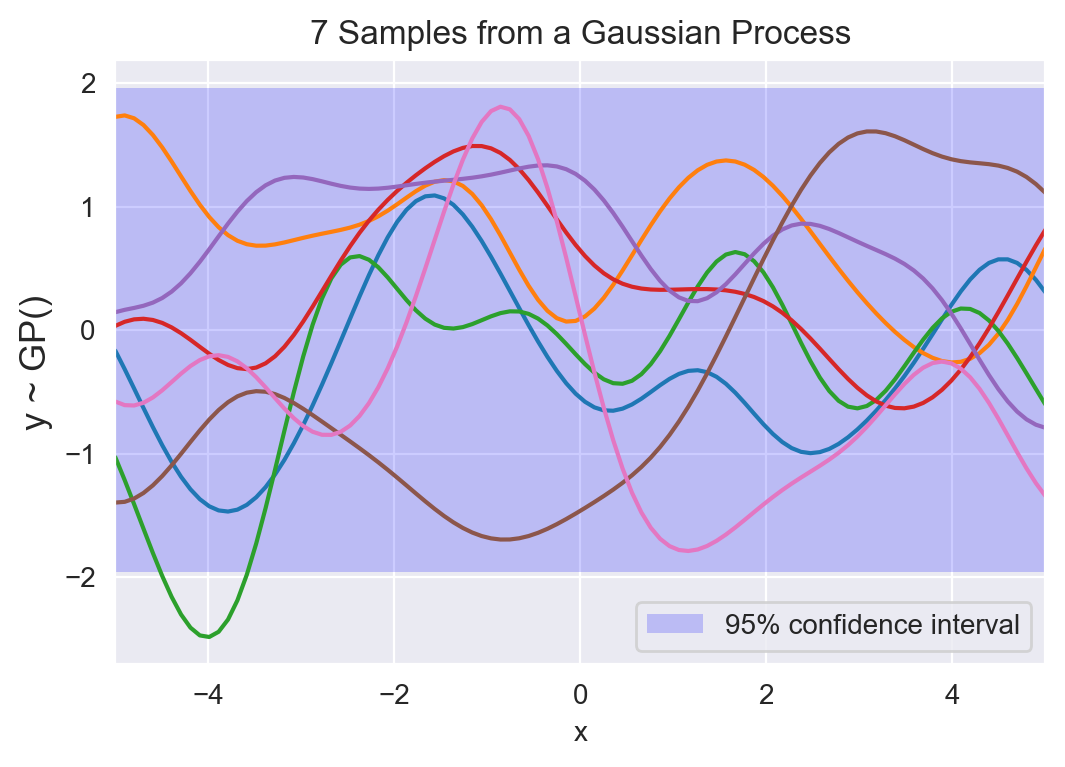

In [3]:
plt.figure(figsize=(6, 4), dpi=100)
sns.color_palette("husl", 8)

_sigma = 1 #kernel([[0]], [[0]])

plt.fill(np.concatenate([X, X[::-1]]),
         np.concatenate([np.zeros(X.shape[0]) - 1.9600 * _sigma,
                        (np.zeros(X.shape[0]) + 1.9600 * _sigma)[::-1]]),
         alpha=.2, fc='b', ec='None', label='95% confidence interval')
for i in range(n_func):
    plt.plot(X, ys[i], linestyle='-') #, marker='o', markersize=3)
    
plt.xlabel('x')
plt.ylabel('y ~ GP()', fontsize=13)
plt.title('%i Samples from a Gaussian Process' % n_func)
plt.xlim([L, U])
plt.legend()
plt.show();

## Gaussian Process error bars

Interested in what the error bars are. Are they 95% confidence intervals?

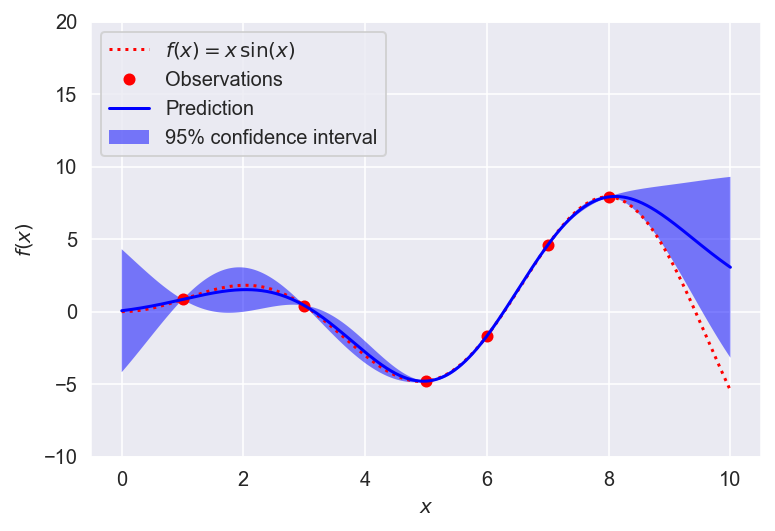

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)

def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.linspace(0, 10, 1000).reshape(-1, 1)

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left');

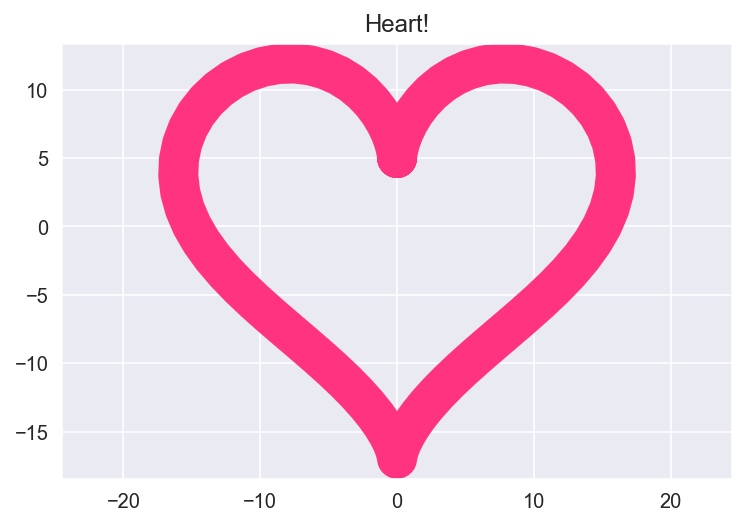

In [5]:
t = np.linspace(0,2*np.pi,100)

x = 16*np.sin(t)**3
y = 13*np.cos(t) - 5*np.cos(2*t) - 2*np.cos(3*t) - np.cos(4*t)

# Plot line with RGB tuple (red=1, green=0.2, blue=0.5)
# and 20pt line width
plt.plot(x,y,c=(1,0.2,0.5),lw=20)

# Add features to our figure
plt.title('Heart!')
plt.axis('equal')
# plt.axis('off')

plt.show();

## GPyTorch GP Regression

https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html

In [6]:
import math
import torch
import gpytorch

In [7]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

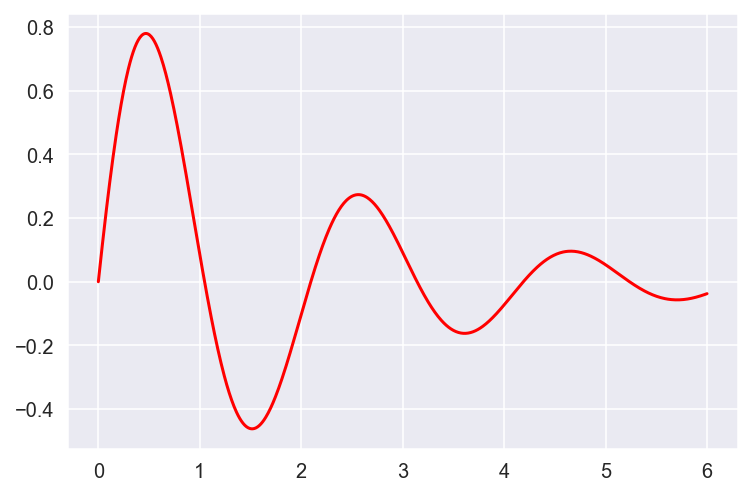

In [11]:
from scipy.stats import norm

g = np.vectorize(lambda y: math.exp(-0.5 * y)*math.sin(3*y))
train_x = np.linspace(0, 6, 750)
train_x=torch.tensor(train_x)

train_y = g(train_x) 
train_y=torch.tensor(train_y)

plt.plot(train_x, train_y, 'r-')
plt.show();

In [12]:
# using GP for exact inference
class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # mean
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # kernel

    def forward(self, x):
        mean_x = self.mean_module(x) 
        covar_x = self.covar_module(x) 
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGP(train_x, train_y, likelihood)

In [15]:
model
for m in model.parameters() :
    print(m)

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

Parameter containing:
tensor([0.], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)
Parameter containing:
tensor(0., requires_grad=True)
Parameter containing:
tensor([[0.]], requires_grad=True)


In [17]:
training_iter = 50
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

Iter 1/50 - Loss: 0.763   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.727   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.690   lengthscale: 0.788   noise: 0.598
Iter 4/50 - Loss: 0.652   lengthscale: 0.800   noise: 0.554
Iter 5/50 - Loss: 0.614   lengthscale: 0.786   noise: 0.513
Iter 6/50 - Loss: 0.575   lengthscale: 0.760   noise: 0.474
Iter 7/50 - Loss: 0.535   lengthscale: 0.730   noise: 0.437
Iter 8/50 - Loss: 0.494   lengthscale: 0.700   noise: 0.403
Iter 9/50 - Loss: 0.453   lengthscale: 0.674   noise: 0.370
Iter 10/50 - Loss: 0.411   lengthscale: 0.655   noise: 0.340
Iter 11/50 - Loss: 0.368   lengthscale: 0.643   noise: 0.312
Iter 12/50 - Loss: 0.324   lengthscale: 0.637   noise: 0.286
Iter 13/50 - Loss: 0.280   lengthscale: 0.635   noise: 0.261
Iter 14/50 - Loss: 0.236   lengthscale: 0.636   noise: 0.239
Iter 15/50 - Loss: 0.191   lengthscale: 0.636   noise: 0.218
Iter 16/50 - Loss: 0.145   lengthscale: 0.633   noise: 0.199
Iter 17/50 - Loss: 0.099   length

In [ ]:
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])